In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
strategy = tf.distribute.MirroredStrategy()

2025-06-13 17:44:03.533087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749836643.989480      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749836644.130694      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 17:44:28.209219: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Masking, Conv1D, BatchNormalization, Dropout, MaxPooling1D, LSTM, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

In [3]:
def load_ensemble(save_paths):
    models = []
    for save_path in save_paths:
        models.append(load_model(save_path))
    return models

def predict(X, models):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
    return np.mean(predictions, axis=0)

In [4]:
X_test = np.load('/kaggle/input/ml-tw-parkinsons-feature-selection/X_test.npy')
y_test = np.load('/kaggle/input/ml-tw-parkinsons-feature-selection/y_test.npy')

In [5]:
models_folder = '/kaggle/input/ml-tw-parkinsons-feature-selection/best_models/'
model_paths = [models_folder + model_path for model_path in os.listdir(models_folder)]
models = load_ensemble(model_paths)

In [6]:
with open('/kaggle/input/ml-tw-parkinsons-feature-selection/features_indices.txt','r') as f:
    features = list(map(int, f.readline().split()))

In [7]:
y_pred = predict(X_test[:,:,features],models)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy on test data: {accuracy_score(y_test, y_pred>0.5):.4f}')
print(f'Precision on test data: {precision_score(y_test, y_pred>0.5):.4f}')
print(f'Recall on test data: {recall_score(y_test, y_pred>0.5):.4f}')
print(f'F1 on test data: {f1_score(y_test, y_pred>0.5):.4f}')
print(f'ROC-AUC on test data: {roc_auc:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Accuracy on test data: 0.7000
Precision on test data: 0.7500
Recall on test data: 0.7059
F1 on test data: 0.7273
ROC-AUC on test data: 0.8009


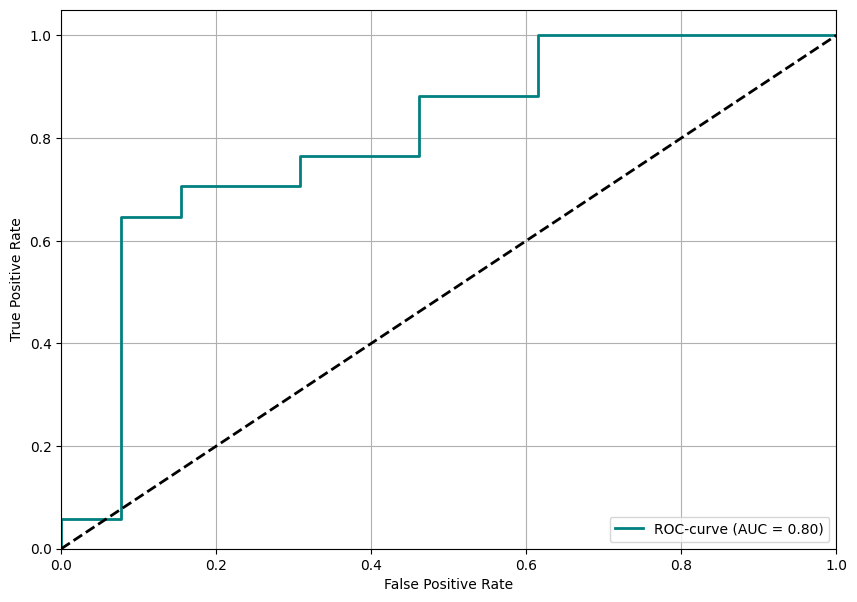

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='teal', lw=2, label=f'ROC-curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()